In [1]:
from typing import Optional, Sequence, Tuple, Dict

import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.circuit.library import TwoLocal
from qiskit.opflow import PauliSumOp
from qiskit.result import Result
from qiskit.algorithms.optimizers import Optimizer, COBYLA

from qiskit_ibm_runtime import QiskitRuntimeService

from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import PySCFDriver
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem

from quantum_serverless import QuantumServerless, run_qiskit_remote, get

from circuit_knitting_toolbox.entanglement_forging import EntanglementForgingAnsatz, cholesky_decomposition, EntanglementForgingKnitter, EntanglementForgingGroundStateSolver

In [2]:
molecule = Molecule(
    geometry=[
        ("H", [0.0, 0.0, 0.0]),
        ("H", [0.0, 0.0, 0.735]),
    ],
    charge=0,
    multiplicity=1,
)
driver = PySCFDriver.from_molecule(molecule=molecule, basis="sto3g")
problem = ElectronicStructureProblem(driver)
converter = QubitConverter(JordanWignerMapper())

In [3]:
ansatz = EntanglementForgingAnsatz(
    circuit_u=TwoLocal(2, [], "cry", [[0, 1], [1, 0]], reps=1),
    bitstrings_u=[(1, 0), (0, 1)],
)

ansatz.circuit_u.draw()

┌──────────────────────┐
q_0: ┤0                     ├
     │  TwoLocal(θ[0],θ[1]) │
q_1: ┤1                     ├
     └──────────────────────┘

In [4]:
# By default, use a local simulator to implement the Qiskit Runtime Primitives
service = None

# Uncomment the following line to instead use the Qiskit Runtime Service.
#service = QiskitRuntimeService(channel="ibm_quantum")

backend_names = ["ibmq_qasm_simulator"] * 2

In [5]:
serverless = QuantumServerless()
serverless.providers()

[<Provider: local>]

In [9]:
@run_qiskit_remote()
def solve_remote(
    problem: ElectronicStructureProblem,
    ansatz_circuit: EntanglementForgingAnsatz,
    optimizer: Optimizer,
    service_args: Optional[Dict] = None,
    backend_names: Optional[Sequence[str]] = None,
    initial_point: Optional[Sequence[float]] = None,
    orbitals_to_reduce: Optional[Sequence[int]] = None,
) -> Result:
    """
    Wrapper function for running entanglement forging VQE on a remote resource.
            
        Args:
            - problem: A class encoding the problem to be solved
            - ansatz: The ansatz
            - optimizer: Optimizer to use to optimize the ansatz circuit parameters
            - service_args: The arguments for instantiating a QiskitRuntimeService
            - backend_names: List of backend names to use during parallel computation
            - initial_point: Initial values for ansatz parameters
            - orbitals_to_reduce: List of orbital indices to remove from the problem before
                decomposition.
        Returns:
            - An interpreted EigenstateResult
    """
    service = QiskitRuntimeService(**service_args) if service_args else None

    solver = EntanglementForgingGroundStateSolver(
        ansatz=ansatz,
        service=service,
        optimizer=optimizer,
        backend_names=backend_names,
        initial_point=initial_point,
        orbitals_to_reduce=orbitals_to_reduce,
    )
    result = solver.solve(problem)
    
    return result

In [10]:
optimizer = COBYLA()
service_args = None if service is None else service.active_account()
initial_point = [0.0, np.pi / 2]

with serverless:
    forging_result_future = solve_remote(problem, ansatz, optimizer, service_args=service_args, backend_names=backend_names, initial_point=initial_point)
    results = get(forging_result_future)

Energy:


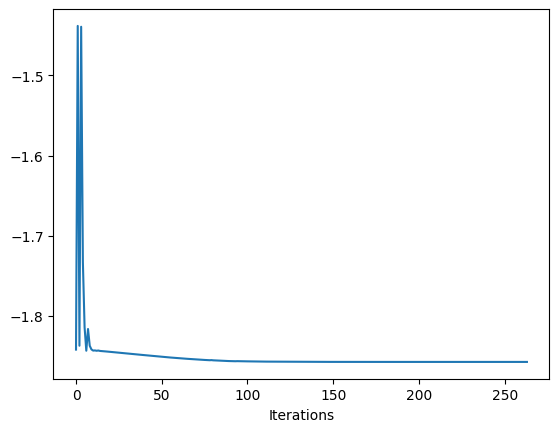

Schmidt Coefficients:


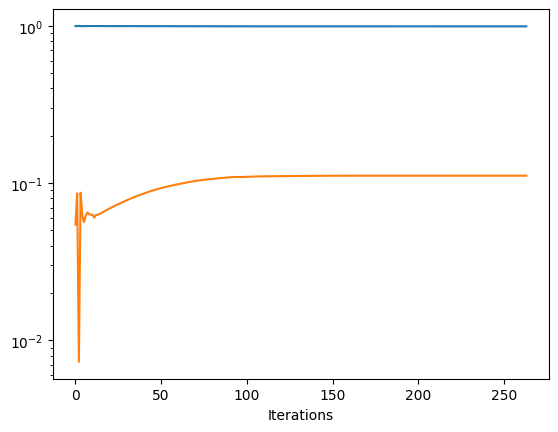

Parameters:


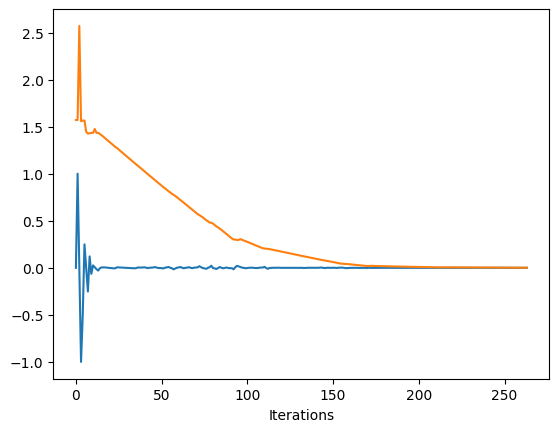

In [11]:
print("Energy:")
plt.plot([evaluation.eigenvalue for evaluation in results.history])
plt.xlabel("Iterations")
plt.show()

print("Schmidt Coefficients:")
plt.plot([abs(evaluation.eigenstate) for evaluation in results.history])
plt.xlabel("Iterations")
plt.yscale("log")
plt.show()

print("Parameters:")
plt.plot([evaluation.parameters for evaluation in results.history])
plt.xlabel("Iterations")
plt.show()